In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth
df = pd.read_csv('ab_log.csv')
df['EventTime'] = df['EventTime'].astype('datetime64[s]')

In [3]:
df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154492 entries, 0 to 154491
Data columns (total 4 columns):
event        154492 non-null object
user_id      154492 non-null int64
EventTime    154492 non-null datetime64[ns]
Group        154492 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.7+ MB


Удалила 296 дубликатов. Количество незначительно и на результаты повлиять не должно. Всего в данных 6805 уникальных пользователей. В среднем по 22 события на каждого. Даты берутся с 25.07.2019 по 05.08.2019. 

In [4]:
df['event'].unique()

array(['StartReadingOffer', 'OpenProductCard', 'StartCheckProduct',
       'OpenPaymentScreen'], dtype=object)

У нас есть 4 вида событий:

1. StartReadingOffer - начал читать предложение о продукте;
2. StartCheckProduct - начал пробовать продукт;
3. OpenProductCard - открыл полную карту с информацией о продукте;
4. OpenPaymentScreen - открыл экран оплаты.

В такой последовательности они будут идти по убыванию количества уникальных пользователей.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


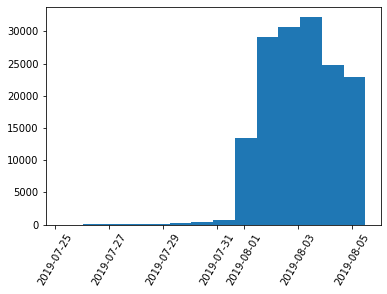

In [5]:
plt.hist(df['EventTime'], bins=14)
plt.xticks(rotation=60)
plt.show()

Здесь мы можем увидеть, что данные начинают накапливаться и давать основательный массив с 01.08.2019. Определим остальные данные за выброс.

In [6]:
data = df[df['EventTime'] >= '2019-08-01'].reset_index(drop=True)

In [7]:
data['Group'].value_counts()

B     54000
A2    48949
A1    48729
Name: Group, dtype: int64

Проверим группы А1 и А2 на проходимость по критериям A/B теста

* Количество пользователей в различных группах различается не более, чем на 1%;
* Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
* Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
* Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [8]:
A1_A2 = data[(data['Group'] == 'A1') | (data['Group'] == 'A2')]
A1 = data[data['Group'] == 'A1']
A2 = data[data['Group'] == 'A2']
B = data[data['Group'] == 'B']

A1['event'].unique()
A2['event'].unique()
B['event'].unique()

(A1['user_id'].nunique()/data['user_id'].nunique() - A2['user_id'].nunique()/data['user_id'].nunique()) * 100
(A1['user_id'].nunique()/data['user_id'].nunique() - B['user_id'].nunique()/data['user_id'].nunique()) * 100
(A2['user_id'].nunique()/data['user_id'].nunique() - B['user_id'].nunique()/data['user_id'].nunique()) * 100

A1_users = A1['user_id'].unique()
A2_users = A2['user_id'].unique()
B_users = B['user_id'].unique()

wrong_usersA1_A2 = A1.query('user_id in @A2_users')
wrong_usersA1_B = A1.query('user_id in @B_users')
wrong_usersA2_B = A2.query('user_id in @B_users')

Количество пользователей разных групп не отличается больше, чем на 1%. Все группы содержат все варианты событий. Проверили, чтобы участники не дублировались в других группах.

In [9]:
def z_test(group1,group2,event1,event2):    
    gr1_event1 = group1[group1['event'] == event1]['user_id'].nunique()
    gr1_event2 = group1[group1['event'] == event2]['user_id'].nunique()
    
    gr2_event1 = group2[group2['event'] == event1]['user_id'].nunique()
    gr2_event2 = group2[group2['event'] == event2]['user_id'].nunique()

    p1 = gr1_event2 / gr1_event1
    p2 = gr2_event2 / gr2_event1
    p_combined = (gr1_event2 + gr2_event2) / (gr1_event1 + gr2_event1)

    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / gr1_event1 + 1 / gr2_event1))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return '{:.4f}'.format(p_value)

data = [['StartReadingOffer-StartCheckProduct',z_test(A1,A2,'StartReadingOffer','StartCheckProduct'),z_test(A1,B,'StartReadingOffer','StartCheckProduct'),z_test(A2,B,'StartReadingOffer','StartCheckProduct'),z_test(A1_A2,B,'StartReadingOffer','StartCheckProduct')],
        ['StartCheckProduct-OpenProductCard',z_test(A1,A2,'StartCheckProduct','OpenProductCard'),z_test(A1,B,'StartCheckProduct','OpenProductCard'),z_test(A2,B,'StartCheckProduct','OpenProductCard'),z_test(A1_A2,B,'StartCheckProduct','OpenProductCard')],
        ['OpenPaymentScreen-OpenProductCard',z_test(A1,A2,'OpenPaymentScreen','OpenProductCard'),z_test(A1,B,'OpenPaymentScreen','OpenProductCard'),z_test(A2,B,'OpenPaymentScreen','OpenProductCard'),z_test(A1_A2,B,'OpenPaymentScreen','OpenProductCard')]]
users_event = pd.DataFrame(data, columns=['conversion','p_value_A1-A2','p_value_A1-B','p_value_A2-B','p_value_A1_A2-B'])
users_event

,conversion,p_value_A1-A2,p_value_A1-B,p_value_A2-B,p_value_A1_A2-B
0,StartReadingOffer-StartCheckProduct,0.1605,0.7287,0.0800,0.2276
1,StartCheckProduct-OpenProductCard,0.8801,0.8238,0.7082,0.7306
2,OpenPaymentScreen-OpenProductCard,0.5705,0.0261,0.0055,0.0058


Мы провели 4 теста. Поэтому уровень alpha необходимо уменьшить во избежание ложнопозитивных исходов. Применим метод Шидака к изначально взятой alpha=0,05 и получим 0,013. При таком значении статистическую значимость получают переходы из "открыл полную карту с информацией о продукте" в "открыл экран оплаты" в сравнении групп 'A2 и B', и 'A1_A2 и B'.

В группе B переходы на экран оплаты увеличились и это увеличение имеет статистически значимую разницу. Можем сделать вывод, что назойливый чат положительно сказывается на увеличении конверсии. Есть смысл его оставить.